# Data preparation

<pre>
Miembros del grupo:
    Alumno1
    Alumno2
</pre>

In [6]:
# We will use pandas, a very widespread library in python
# In case you have never used it, or want to review its documentation
# These are some interesting docs:
# http://pandas.pydata.org/pandas-docs/stable/
# https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html
# https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html
import pandas as pd
%matplotlib inline

### read data

In [7]:
# read_csv is the function that reads csvs, it returns a Pandas dataframe
df = pd.read_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data/prosperLoanData.csv")

In [8]:
# Check number of rows and columns
print ('The DataSet has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

The DataSet has 113937 rows and 81 columns


In [9]:
# Check the columns name
df.columns

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade',
       'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate',
       'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss',
       'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)',
       'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState',
       'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',
       'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'Availa

Algunas de las columnas claves del dataset son:

- **LoanStatus**: Esta variable representa el estado acual del prestamo. Puede tener las siguientes categorías: 'Cancelled', 'Chargedoff', 'Completed', 'Current', 'Default', 'FinalPaymentInProgress' y 'PastDue'. Hay que destacar que este último vendrá acompañado de un 'Delicuency bucket'


- **LoanMonthsSinceOrigination**: Esta variable representa el número de meses transcurridos desde la fecha de originación.


- **LoanFirstDefaultedCycleNumber**: Esta variable representa el ciclo del préstamo hasta que incurrió en Default.


- **LoanCurrentDaysDelinquent**: Esta variable representa el número de días en las que el préstamo incurrío en mora


# Performance & Sample Window

<AxesSubplot: >

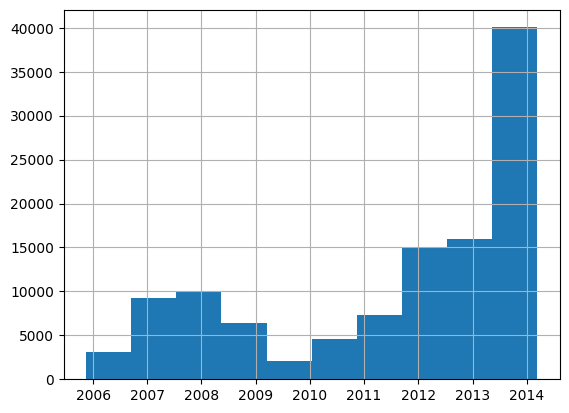

In [10]:
pd.to_datetime(df.LoanOriginationDate.str[:10]).hist()

**TODO 1** Seleccionar y razonar la columna que debería ser usada como input para nuestra variable objetivo. Existen dos opciones:
- Opción A: **LoanStatus** 
- Opción B: **LoanFirstDefaultedCycleNumber** 

Escribe tu respuesta aquí: LoanFirstDefaultedCycleNumber, indica el momento en el que el préstamo entró en default por primera vez. Loanstatus indica el estado del préstamo en el último momento

## Vintage analysis

El análisis Vintage nos permite entender el comportamiento de los prestamos con respecto al bad rate, para cada año de origen del préstamo, y para cada ventana en la que evaluamos si ha habido default.

In [11]:
# Years since loan origination
df['LoanMonthsSinceOriginationY'] = (df.LoanMonthsSinceOrigination / 12).round()
# Quarter in which the Loan defaulted
df['LoanFirstDefaultedCycleNumberQ'] = 4 * (df.LoanFirstDefaultedCycleNumber / 4).round()
# Get the number of loans per origination year
df_vintage = df.groupby('LoanMonthsSinceOriginationY').agg({'LoanMonthsSinceOriginationY': 'size'})\
                                                     .rename(columns={'LoanMonthsSinceOriginationY': 'N_loans'})\
                                                     .reset_index()


# For each year, compute the cummulative sum of defaulted loans per quarter
df['bad_aux'] = ~df['LoanFirstDefaultedCycleNumber'].isna()
df_def_per_cycle = pd.DataFrame(df.groupby(['LoanMonthsSinceOriginationY', 'LoanFirstDefaultedCycleNumberQ'])['bad_aux'].sum().groupby(level=[0]).cumsum()).reset_index()
df_def_per_cycle.columns = df_def_per_cycle.columns[:-1].tolist() +  ['N_bads']

# Merge both data sources, compute the bad rate
df_vintage = df_vintage.merge(df_def_per_cycle, on='LoanMonthsSinceOriginationY')
df_vintage['BR'] = 100. * df_vintage['N_bads'] / df_vintage['N_loans']

df_vintage.head()

,LoanMonthsSinceOriginationY,N_loans,LoanFirstDefaultedCycleNumberQ,N_bads,BR
0,0.0,29808,4.0,1,0.003355
1,0.0,29808,8.0,3,0.010064
2,1.0,21134,0.0,3,0.014195
3,1.0,21134,4.0,18,0.085171
4,1.0,21134,8.0,462,2.186051


In [12]:
# Transform from long to wide format
df_vin_pvt = df_vintage.pivot(index='LoanMonthsSinceOriginationY', columns='LoanFirstDefaultedCycleNumberQ', values='BR')
df_vin_pvt

LoanFirstDefaultedCycleNumberQ,0.0,4.0,8.0,12.0,16.0,20.0,24.0,28.0,32.0,36.0,40.0,44.0
LoanMonthsSinceOriginationY,,,,,,,,,,,,
0.0,NaN,0.003355,0.010064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,0.014195,0.085171,2.186051,2.943125,3.368979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,0.039757,0.462181,5.342411,8.180101,12.160819,13.850512,15.132691,15.321539,15.326508,NaN,NaN,NaN
3.0,0.497830,0.931836,5.731427,8.424815,12.215982,14.003064,16.504978,17.870820,19.019658,19.211131,19.223896,NaN
4.0,1.117222,1.460983,4.417326,6.170505,8.765899,10.072190,12.220694,13.234789,14.575455,15.177037,15.830182,NaN
5.0,0.861009,NaN,6.150062,9.963100,14.022140,15.252153,17.958180,19.311193,20.541205,21.156212,22.017220,NaN
6.0,1.280445,1.851079,8.427279,12.985386,20.215727,23.291580,27.446068,29.485038,31.649269,32.713987,34.036186,34.043145
7.0,1.988015,2.872634,13.297822,18.814801,25.292495,28.659755,33.368211,35.708171,38.761533,40.017122,41.396366,NaN
8.0,1.276596,2.723404,11.177305,15.829787,22.978723,25.929078,29.900709,31.659574,34.269504,35.659574,36.964539,NaN


<AxesSubplot: xlabel='LoanFirstDefaultedCycleNumberQ'>

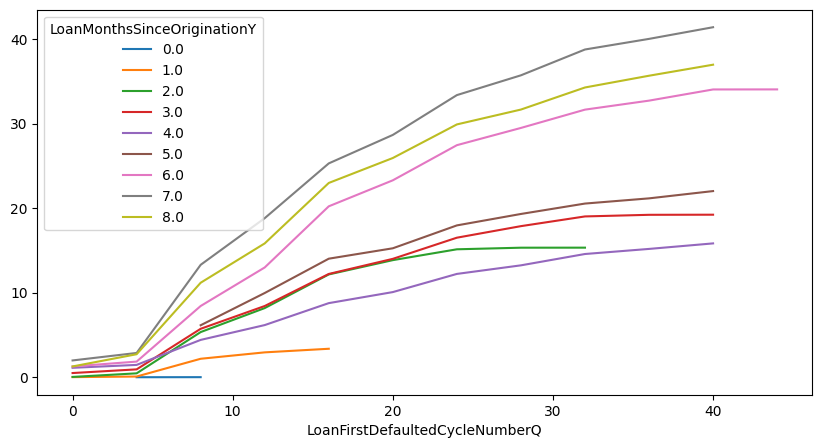

In [13]:
df_vin_pvt.transpose().plot(figsize=(10, 5))

**TODO 2** Explica qué aprendizajes se pueden leer en la gráfica anterior. Razona si los prestamos originados hace 7 años tienen un comportamiento parecido o diferente con respecto a los prestamos originados hace 3 años.

Escribe tu respuesta aquí: Tienen comportamientos diferentes. Los prestamos entre 6 y 8 años tienen una mayor tasa de impago que los préstamos más recientes.

## Good, bad, indeterminate definition

**TODO 3** Implementa una función, que añada las siguientes columnas a nuestro dataframe df:
- **PW**: Captura si el préstamo tiene una madurez(LoanMonthsSinceOrigination) mayor que la PW (Performance window). La variable de entrada PW_size captura el número de meses de la PW.
- **fraud.**: Captura si el préstamo puede considerarse como un caso de fraude. En nuestro caso, consideramos fraude los préstamos que hayan tenido un evento de impago antes de TH_fraud.
- **bad.**: Captura si el préstamo cumple la condición de malo. En nuestro caso, que el evento de impago haya ocurrido después de TH_fraud, y antes del final de la PW
- **indeterm**: Captura si el préstamo se considera indeterminado. Definiremos indeterminados aquellos prestamos que han caído en impago después de la Performance window

In [14]:
# Use fraud threshold = 4 months

def generate_pop_flags(df, PW_size, TH_fraud=4):
    """Generates fraud, bad, and indeterminate columns
    
    Args:
        df: Pandas DataFrame with the input data
        PW_size: Int Performance window size (months)
        TH_fraud: Int number of months used as treshold for fraud
        
    Returns:
        Pandas DataFrame with the columns that capture
        PW, fraud, bad and indeterminate
    """
    ## Implement the function HERE ##
    df_ = df.copy()
    #PW maturity
    df_['PW'] = df_.LoanMonthsSinceOrigination >= PW_size
    #handle fraud 
    df_['fraud'] = df_.LoanFirstDefaultedCycleNumber <= TH_fraud
    #bad definition
    df_['bad'] = (df_.LoanFirstDefaultedCycleNumber > TH_fraud) & (df_.LoanFirstDefaultedCycleNumber <= PW_size)
    #indeterminates
    df_['indeterm'] = (df_.LoanFirstDefaultedCycleNumber > PW_size)
    return df_

**TODO 4** Para diferentes PW_size (se recomiendan evaluar los siguientes valores: 6, 9, 12, 15 y 18), evalúa el volumen y ratio de prestamos con madurez, prestamos fraudulentos, prestamos que cumplan la definición de bad, y préstamos que se consideren indeterminados. Por último, argumenta cuál es el valor de PW_size que se debería usar. La función se debe usar con el valor por defecto de  TH_fraud=4

In [15]:
for pw_eval in [6, 9, 12, 15, 18]:
    print(f"Results for PW={pw_eval}")
    df_eval = generate_pop_flags(df, pw_eval)
    display(df_eval[["PW", "fraud", "bad", "indeterm"]].sum() / len(df_eval))

Results for PW=6


PW          0.766345
fraud       0.004933
bad         0.009619
indeterm    0.134232
dtype: float64

Results for PW=9


PW          0.685774
fraud       0.004933
bad         0.033712
indeterm    0.110140
dtype: float64

Results for PW=12


PW          0.623467
fraud       0.004933
bad         0.056145
indeterm    0.087706
dtype: float64

Results for PW=15


PW          0.591731
fraud       0.004933
bad         0.075709
indeterm    0.068143
dtype: float64

Results for PW=18


PW          0.552893
fraud       0.004933
bad         0.092639
indeterm    0.051213
dtype: float64

In [16]:
PW_size = 12# Aplica el valor determinado en el TODO anterior
df = generate_pop_flags(df, PW_size)

## First exclusion set

**TODO 5** Implementa una función que ejecutará las exclusiones a nuestro dataframe. La función debe excluir los siguientes préstamos:
- Préstamos que tengan una madurez menor que la PW
- Préstamos que se consideren como fraude
    

In [17]:
df["PW"]

0          True
1         False
2          True
3          True
4         False
          ...  
113932    False
113933     True
113934    False
113935     True
113936    False
Name: PW, Length: 113937, dtype: bool

In [18]:
def filter_exclusions(df):
    """Function that handles the population definition
    
    Args:
        df: Pandas DataFrame with the in time input data
        
    Returns:
        Pandas DataFrame with the population definition applied
    """
    ## Implement the function HERE ##
    return df.loc[df["PW"]].loc[~df["fraud"]]
    

In [19]:
df = filter_exclusions(df)
print ('The DataSet has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

The DataSet has 70475 rows and 88 columns


## Bad rate

In [20]:
df.bad.value_counts()

False    64266
True      6209
Name: bad, dtype: int64

In [21]:
100. * df.bad.value_counts() / df.shape[0]

False    91.189784
True      8.810216
Name: bad, dtype: float64

In [22]:
df[['ListingCreationDate', 'LoanOriginationDate']].head()

,ListingCreationDate,LoanOriginationDate
0,2007-08-26 19:09:29.263000000,2007-09-12 00:00:00
2,2007-01-05 15:00:47.090000000,2007-01-17 00:00:00
3,2012-10-22 11:02:35.010000000,2012-11-01 00:00:00
10,2012-05-10 07:04:01.577000000,2012-05-17 00:00:00
11,2007-10-09 20:28:33.640000000,2007-10-18 00:00:00


In [23]:
df['LoanOriginationDate'] = pd.to_datetime(df.LoanOriginationDate.str[:10])
df['LoanOriginationYear'] = pd.to_datetime(df.LoanOriginationDate.values).year

## Additional exclusions

Una vez aplicadas las exclusiones anteriores, vamos a estudiar la tasa de malos por año de origen del préstamo.

**TODO 6** Implementa una función agregue los préstamos por año (LoanOriginationYear), y compute el número de prestamos, el número de "malos" y la tasa de malos.

In [24]:
def describe_yearly_BR(df, col_year, col_target):
    """Describes the yearly number of loans, bad loans and bad rate of the portfolio
    
    Args:
        df: Pandas DataFrame with the input data
        col_year: Name of the column that captures the loan origination date
        col_target: Name of the target column
        
    Returns:
        Pandas DataFrame with the yearly number of loans, bad 
        loans and bad rate of the portfolio 
    """
    ## Implement the function HERE ##
    return df.groupby(col_year)[col_target].mean()

In [25]:
describe_yearly_BR(df, "LoanOriginationYear", "bad")

LoanOriginationYear
2005    0.000000
2006    0.154414
2007    0.133808
2008    0.102533
2009    0.048228
2010    0.044990
2011    0.073073
2012    0.068611
2013    0.035122
Name: bad, dtype: float64

**TODO 7** Usando los resultados obtenidos por la función describe_yearly_BR, define cuál será la Sample Window (qué años se consideraran para capturar préstamos en la población). La Sample Window debe de cumplir las siguientes condiciones: 
- Debe de tener un ratio de positivos (malos, en nuestro caso) aproximadamente constante
- Debe de capturar un periodo que en principio debería representar el entorno en que se usará el modelo
- Debe de capturar un periodo lo más reciente posible

Define también qué periodo temporal capturará la muestra IT (In Time), y la muestra OOT (Out of time).

### Final output sampling:

   

 - IT (In Time):
     - Train
     - Validation 
     - Reject Inference sample
 - OOT (Out of time)


In [32]:
df["bad"]

0         False
2         False
3         False
10        False
11        False
          ...  
113926    False
113927    False
113928    False
113933    False
113935    False
Name: bad, Length: 70475, dtype: bool

In [26]:
import datetime as dt

In [27]:
filtro1 = df.LoanOriginationYear >= 2009
filtro2 = df.LoanOriginationDate <= dt.datetime(2012, 6, 30)
df_it = df[(filtro1 & filtro2)] # Keep the time period as defined in the previous TODO
# Split randomly in train, validation and RI
# - 60% Train, 20% val, 20% RI
df_train = df_it.sample(frac=0.6, random_state=42)
df_val_ri = df_it.loc[~df_it.index.isin(df_train.index)]
df_val = df_val_ri.sample(frac=0.5, random_state=42)
df_ri = df_val_ri.loc[~df_val_ri.index.isin(df_val.index)]

In [28]:
df_oot = df.loc[df.LoanOriginationDate > dt.datetime(2012, 6, 30)] # Keep the time period as defined in the previous TODO

In [29]:
len(df_it), len(df_train), len(df_val), len(df_ri), len(df_oot)

(28311, 16987, 5662, 5662, 13669)

In [30]:
# Write everything
"/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data/prosperLoanData_oot.csv"
df_train.to_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data/prosperLoanData_train.csv", index=False)
df_val.to_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data/prosperLoanData_val.csv", index=False)
df_ri.to_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data/prosperLoanData_ri.csv", index=False)
df_oot.to_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data/prosperLoanData_oot.csv", index=False)